In [79]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import requests
from urllib.parse import urlencode
from scipy import stats
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt

In [2]:
def get_data(url, sep):
    '''
    Функция для того чтобы считать данные из яндекс диска с помощью API c разделителем по умолчанию
    '''
    # используем api 
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
    public_key = url 
 
    # получаем url 
    final_url = base_url + urlencode(dict(public_key=public_key)) 
    response = requests.get(final_url) 
    download_url = response.json()['href'] 
 
    # загружаем файл в df 
    df = pd.read_csv(download_url, sep=sep)
    return df

In [3]:
# сохраняем переменные со ссылками на входные данные
groups_url = 'https://disk.yandex.ru/d/58Us0DWOzuWAjg'
groups_add_url = 'https://disk.yandex.ru/d/3aARY-P9pfaksg'
active_url = 'https://disk.yandex.ru/d/prbgU-rZpiXVYg'
checks_url = 'https://disk.yandex.ru/d/84hTmELphW2sqQ'

In [5]:
# считываем данные 
groups = get_data(groups_url, sep=';')
active = get_data(active_url, sep=',')  
checks = get_data(checks_url, sep=';')

In [6]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


# 1.1 Условие

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

In [7]:
# переименуем колонку в таблице
groups = groups.rename(columns={'id' : 'student_id'})

In [8]:
# добавим информацию о группе для активных пользователей
full_info = active.merge(groups, on='student_id', how='left')

In [9]:
# посмотрим есть ли пропущенные значения
full_info.isna().sum()

student_id     0
grp           13
dtype: int64

In [10]:
# очистим данные от пустых значений
full_info = full_info.dropna()

In [11]:
full_info.groupby('grp', as_index=False)\
    .agg({'student_id' : 'count'})

,grp,student_id
0,A,1535
1,B,6793


In [12]:
# прежде чем добавить информацию о покупках проверим есть ли студенты которые платили повторно
checks.shape[0] == checks.student_id.nunique()

True

In [13]:
# добавляем информацию о покупках
full_info = full_info.merge(checks, on='student_id', how='left')\
                     .fillna(0)

In [14]:
full_info

,student_id,grp,rev
0,581585,A,0.0
1,3276743,B,0.0
2,4238589,A,0.0
3,4475369,B,0.0
4,5481015,B,0.0
...,...,...,...
8323,1794344,B,0.0
8324,296883,B,0.0
8325,3598448,B,0.0
8326,3610547,B,290.0


Так как целью эксперимента является оценить влияние некой новой системы оплаты на сайте, разумным было бы оценить влияние на платящих пользователей. Да, так мы теряем часть данных, но в дальнейшем рассмотрим влияние эксперимента на другую метрику - CR. 

In [18]:
# посчитаем ARPPU 
full_info.query('rev > 0').groupby('grp')\
    .agg({'rev' : 'mean'})\
    .rename(columns={'rev' : 'ARPU'})

,ARPU
grp,
A,933.589744
B,1255.827487


Заметим, что средний чек по группам значительно отличается, но являются ли эти различия стат. значимыми?

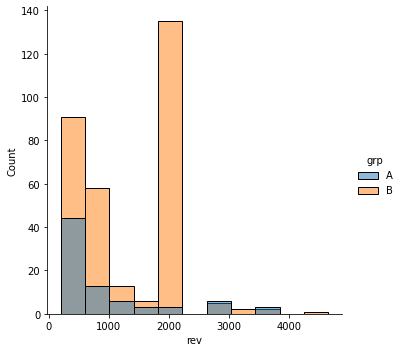

In [20]:
# посмотрим как распределены чеки в зависимости от группы
sns.displot(data=full_info.query('rev > 0'), x='rev', hue='grp')

In [ ]:
Видим, что распределение чеков явно не нормальное, сильно скошено влево. Попробуем применить логарифм.

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


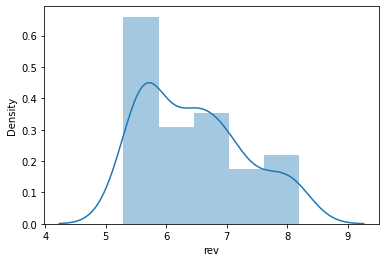

In [17]:
sns.distplot(full_info.query('grp == "A" and rev > 0').rev.apply(np.log))

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


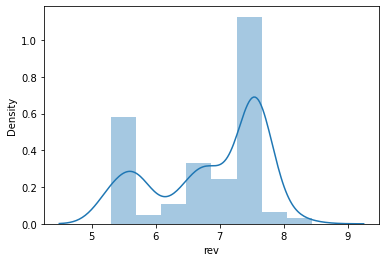

In [18]:
sns.distplot(full_info.query('grp == "B" and rev > 0').rev.apply(np.log))

Заметим, что распределения конечно стали более симметричными, но все еще далеки от нормального. Требование нормальности не выполняется, но давайте проверим требование на равенство дисперсий. Если не выполнится и оно - это повод отказаться от использования t-test.

In [16]:
stats.levene(full_info.query('grp == "A" and rev > 0').rev.apply(np.log),
             full_info.query('grp == "B" and rev > 0').rev.apply(np.log))

LeveneResult(statistic=0.10794168834088425, pvalue=0.7426765607631863)

Видим, что требование о равенстве дисперсий выполняется. Поэтому мы все-таки воспользуемся t-test, чтобы не прибегать к другим методам. Да, так мы увеличиваем вероятность ошибки, но все-таки мы знаем, что t-test на практике можем давать корректные результаты даже на не нормальных распределениях.

In [89]:
# наконец проведем t-test и посмотрим насколько статистически значимы различия
# используем логарифм для того чтобы "нормализовать" распределения
ttest_ind(full_info.query('grp == "A" and rev > 0').rev.apply(np.log),
             full_info.query('grp == "B" and rev > 0').rev.apply(np.log))

Ttest_indResult(statistic=-3.680420288303037, pvalue=0.0002656980812762601)

Видим, что pvalue достаточно низкий чтобы говорить о статистически значимых различиях. 
Эксперимент определенно повлиял на средний чек.

Заметим, что в общем случае то, что t-test показал стат значисые результаты на лог трансформированных данных не значит что они были в исходных. Но мы провели тест Левене и выяснили, что дисперсии равны, поэтому можно говорить и о том, что в исходных данных тоже есть стат значимые различия.

Нам пришлось отбросить значимую часть данных (тех кто не совершил покупку), поэтому целесообразно еще посмотреть на то как экcперимент повлиял на конверсию

In [33]:
# подготовим колонку для подсчета конверсии
full_info['CR'] = full_info.rev != 0

In [34]:
# посмотрим на конверсию по группам
full_info.groupby('grp')\
    .agg({'CR' : 'mean'})

,CR
grp,
A,0.050814
B,0.046077


Видим, что конверсия в тестовой группе упала, но надо понять насколько это различие стат. значимо. Также необходимо помнить, что размеры выборок сильно несбалансированы 

In [29]:
# подготовим данные для матрицы, которую оценим с помощью критерия хи-квадрат
A_freqs = list(full_info.query('grp == "A"').CR.value_counts())
B_freqs = list(full_info.query('grp == "B"').CR.value_counts())

In [34]:
# используем гоовую функцию для проведения стат теста 
obs = np.array([A_freqs, B_freqs])
chi2, p, dof, ex = chi2_contingency(obs)
print(f'statistics is {chi2}\npvalue is {p}')

statistics is 0.526607176998989
pvalue is 0.46803677583199144


Как мы видим, данные не позволяют точно сказать, что эксперимент повлиял на конверсию, а значит при той же конверсии мы имеем повышение среднего чека. Значит определенно надо выкатывать обновление на всех пользователей 

Задание 2. SQL
2.1 Очень усердные ученики.

2.1.1 Условие

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

2.1.2 Задача

Дана таблица default.peas:

Название атрибута	Тип атрибута 	Смысловое значение
st_id	int	ID ученика
timest	timestamp	Время решения карточки
correct	bool	Правильно ли решена горошина?
subject	text	Дисциплина, в которой находится горошина
Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.

NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

In [ ]:
# для начала проверим за какой промежуток времени у нас есть данные
select
    min(timest),
    max(timest)
from peas

Результат:
  min(timest)                   max(timest)
2021-10-30 13:00:00.000  2021-10-31 17:29:52.000

То есть данные есть только за два дня 

In [ ]:
''' теперь посчитаем количество усердных студентов:
1)для этого посчитаем количество правильно решенных задач у каждого
2)отфильтруем тех у кого количество не менее 20
3)посчитаем количество строк
'''
SELECT
    count(*) as good_students
from
    (
    select 
        st_id,
        sum(correct) as correct_num
    from peas
    group by
        st_id
    having 
        correct_num >= 20
    )

In [ ]:
Результат: 136


2.2 Оптимизация воронки

2.2.1 Условие

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

2.2.2 Задача

Дана таблицы: default.peas (см. выше), default.studs:

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

ARPU 
ARPAU 
CR в покупку 
СR активного пользователя в покупку 
CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике
ARPU считается относительно всех пользователей, попавших в группы.

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

In [ ]:
'''
1) Надо сначала создать таблицу, где для каждого студента будут колонки: test_grp,
                                                                         revenue(сумма покупок на платформе), 
                                                                         CR (1 если совершал покупки, 0 если нет),
                                                                         active (1 если пользователь активный, 0 если нет)
                                                                         math_active (активность по математике),
                                                                         math_CR (совершал ли пользователь покупки по математике)

2)Посчитать ARPU
3)Считаем ARPAU
4)Считаем CR
5)Считаем СR для активных студентов
6)Считаем CR из активности по математике в покупку по математике
7)Соединяем все это в одну таблицу
'''

In [ ]:
ЗАПРОС:
select  
    a.test_grp as test_grp,
    a.ARPU as ARPU,
    b.ARPAU as ARPAU,
    d.CR as CR,
    c.CR_active as CR_active,
    e.math_CR as math_CR
from
    (
    -- считаем ARPU по группам
    select  
        test_grp,
        avg(revenue) as ARPU
    from 
        (
        SELECT
           a.st_id as st_id,
           a.test_grp as test_grp,
           a.active as active,
           a.CR as CR,
           a.revenue as revenue,
           b.math_active as math_active,
           b.math_CR as math_CR
        from
            (
            -- создадим таблицу с колонками: st_id, test_grp, active(1 если активный, 0 если нет), CR(1 если совершал покупки, 0 если нет)
            SELECT
                a.st_id as st_id,
                a.test_grp as test_grp,
                if(b.correct_num > 10, 1, 0) as active,
                if(c.revenue == 0, 0, 1) as CR,
                c.revenue as revenue
            from studs as a
            left JOIN 
                (
                SELECT 
                    st_id,
                    sum(correct) as correct_num
                FROM peas 
                group by 
                    st_id
                ) as b
            on a.st_id = b.st_id
            LEFT JOIN  
                (
                select
                    st_id,
                    sum(money) as revenue
                from final_project_check
                group by
                    st_id
                ) as c
                ON a.st_id = c.st_id
            ) as a
        left join   
            (-- создаем таблицу с активностью и конверсией по математике
            select
                a.st_id as st_id,
                if(a.math_correct >=2 , 1, 0) as math_active,
                if(b.revenue == 0, 0, 1) as math_CR
            from
                (
                select 
                    st_id,
                    sum(correct) as math_correct
                from peas
                where 
                    subject == 'Math'
                group by 
                    st_id
                ) as a
            left join
                (
                select
                    st_id,
                    sum(money) as revenue
                from final_project_check
                where
                    subject == 'Math'
                group by
                    st_id
                ) as b
            on a.st_id = b.st_id
            ) as b
        on a.st_id = b.st_id
        ) 
    group by
        test_grp
    ) as a
JOIN
    (
    -- считаем ARPAU по группам
    select  
        test_grp,
        avg(revenue) as ARPAU
    from 
        (
        SELECT
           a.st_id as st_id,
           a.test_grp as test_grp,
           a.active as active,
           a.CR as CR,
           a.revenue as revenue,
           b.math_active as math_active,
           b.math_CR as math_CR
        from
            (
            -- создадим таблицу с колонками: st_id, test_grp, active(1 если активный, 0 если нет), CR(1 если совершал покупки, 0 если нет)
            SELECT
                a.st_id as st_id,
                a.test_grp as test_grp,
                if(b.correct_num > 10, 1, 0) as active,
                if(c.revenue == 0, 0, 1) as CR,
                c.revenue as revenue
            from studs as a
            left JOIN 
                (
                SELECT 
                    st_id,
                    sum(correct) as correct_num
                FROM peas 
                group by 
                    st_id
                ) as b
            on a.st_id = b.st_id
            LEFT JOIN  
                (
                select
                    st_id,
                    sum(money) as revenue
                from final_project_check
                group by
                    st_id
                ) as c
                ON a.st_id = c.st_id
            ) as a
        left join   
            (-- создаем таблицу с активностью и конверсией по математике
            select
                a.st_id as st_id,
                if(a.math_correct >=2 , 1, 0) as math_active,
                if(b.revenue == 0, 0, 1) as math_CR
            from
                (
                select 
                    st_id,
                    sum(correct) as math_correct
                from peas
                where 
                    subject == 'Math'
                group by 
                    st_id
                ) as a
            left join
                (
                select
                    st_id,
                    sum(money) as revenue
                from final_project_check
                where
                    subject == 'Math'
                group by
                    st_id
                ) as b
            on a.st_id = b.st_id
            ) as b
        on a.st_id = b.st_id
        ) 
    where
        active == 1
    group by
        test_grp
    ) as b  
on a.test_grp = b.test_grp
join  
    (
    -- считаем CR_active по группам
    select  
        test_grp,
        avg(CR) as CR_active
    from 
        (
        SELECT
           a.st_id as st_id,
           a.test_grp as test_grp,
           a.active as active,
           a.CR as CR,
           a.revenue as revenue,
           b.math_active as math_active,
           b.math_CR as math_CR
        from
            (
            -- создадим таблицу с колонками: st_id, test_grp, active(1 если активный, 0 если нет), CR(1 если совершал покупки, 0 если нет)
            SELECT
                a.st_id as st_id,
                a.test_grp as test_grp,
                if(b.correct_num > 10, 1, 0) as active,
                if(c.revenue == 0, 0, 1) as CR,
                c.revenue as revenue
            from studs as a
            left JOIN 
                (
                SELECT 
                    st_id,
                    sum(correct) as correct_num
                FROM peas 
                group by 
                    st_id
                ) as b
            on a.st_id = b.st_id
            LEFT JOIN  
                (
                select
                    st_id,
                    sum(money) as revenue
                from final_project_check
                group by
                    st_id
                ) as c
                ON a.st_id = c.st_id
            ) as a
        left join   
            (-- создаем таблицу с активностью и конверсией по математике
            select
                a.st_id as st_id,
                if(a.math_correct >=2 , 1, 0) as math_active,
                if(b.revenue == 0, 0, 1) as math_CR
            from
                (
                select 
                    st_id,
                    sum(correct) as math_correct
                from peas
                where 
                    subject == 'Math'
                group by 
                    st_id
                ) as a
            left join
                (
                select
                    st_id,
                    sum(money) as revenue
                from final_project_check
                where
                    subject == 'Math'
                group by
                    st_id
                ) as b
            on a.st_id = b.st_id
            ) as b
        on a.st_id = b.st_id
        ) 
    where
        active == 1
    group by
        test_grp
    ) as c 
on a.test_grp = c.test_grp
join    
    (
    -- считаем конверсию по группам
    select  
        test_grp,
        avg(CR) as CR
    from 
        (
        SELECT
           a.st_id as st_id,
           a.test_grp as test_grp,
           a.active as active,
           a.CR as CR,
           a.revenue as revenue,
           b.math_active as math_active,
           b.math_CR as math_CR
        from
            (
            -- создадим таблицу с колонками: st_id, test_grp, active(1 если активный, 0 если нет), CR(1 если совершал покупки, 0 если нет)
            SELECT
                a.st_id as st_id,
                a.test_grp as test_grp,
                if(b.correct_num > 10, 1, 0) as active,
                if(c.revenue == 0, 0, 1) as CR,
                c.revenue as revenue
            from studs as a
            left JOIN 
                (
                SELECT 
                    st_id,
                    sum(correct) as correct_num
                FROM peas 
                group by 
                    st_id
                ) as b
            on a.st_id = b.st_id
            LEFT JOIN  
                (
                select
                    st_id,
                    sum(money) as revenue
                from final_project_check
                group by
                    st_id
                ) as c
                ON a.st_id = c.st_id
            ) as a
        left join   
            (-- создаем таблицу с активностью и конверсией по математике
            select
                a.st_id as st_id,
                if(a.math_correct >=2 , 1, 0) as math_active,
                if(b.revenue == 0, 0, 1) as math_CR
            from
                (
                select 
                    st_id,
                    sum(correct) as math_correct
                from peas
                where 
                    subject == 'Math'
                group by 
                    st_id
                ) as a
            left join
                (
                select
                    st_id,
                    sum(money) as revenue
                from final_project_check
                where
                    subject == 'Math'
                group by
                    st_id
                ) as b
            on a.st_id = b.st_id
            ) as b
        on a.st_id = b.st_id
        ) 
    group by
        test_grp
    ) as d   
on a.test_grp = d.test_grp
join   
    (
    -- считаем math_CR по группам
    select  
        test_grp,
        avg(math_CR) as math_CR
    from 
        (
        SELECT
           a.st_id as st_id,
           a.test_grp as test_grp,
           a.active as active,
           a.CR as CR,
           a.revenue as revenue,
           b.math_active as math_active,
           b.math_CR as math_CR
        from
            (
            -- создадим таблицу с колонками: st_id, test_grp, active(1 если активный, 0 если нет), CR(1 если совершал покупки, 0 если нет)
            SELECT
                a.st_id as st_id,
                a.test_grp as test_grp,
                if(b.correct_num > 10, 1, 0) as active,
                if(c.revenue == 0, 0, 1) as CR,
                c.revenue as revenue
            from studs as a
            left JOIN 
                (
                SELECT 
                    st_id,
                    sum(correct) as correct_num
                FROM peas 
                group by 
                    st_id
                ) as b
            on a.st_id = b.st_id
            LEFT JOIN  
                (
                select
                    st_id,
                    sum(money) as revenue
                from final_project_check
                group by
                    st_id
                ) as c
                ON a.st_id = c.st_id
            ) as a
        left join   
            (-- создаем таблицу с активностью и конверсией по математике
            select
                a.st_id as st_id,
                if(a.math_correct >=2 , 1, 0) as math_active,
                if(b.revenue == 0, 0, 1) as math_CR
            from
                (
                select 
                    st_id,
                    sum(correct) as math_correct
                from peas
                where 
                    subject == 'Math'
                group by 
                    st_id
                ) as a
            left join
                (
                select
                    st_id,
                    sum(money) as revenue
                from final_project_check
                where
                    subject == 'Math'
                group by
                    st_id
                ) as b
            on a.st_id = b.st_id
            ) as b
        on a.st_id = b.st_id
        ) 
    where
        math_active == 1
    group by
        test_grp
    ) as e
on a.test_grp = e.test_grp

In [43]:
# выведем таблицу из табикса и приведем к более читаемому виду
result = pd.read_csv('result.csv')
result.CR = result.CR.mul(100)
result.CR_active = result.CR_active.mul(100)
result.math_CR = result.math_CR.mul(100)
result.round(2)

,test_grp,ARPU,ARPAU,CR,CR_active,math_CR
0,control,4540.98,10393.70,4.92,11.02,6.12
1,pilot,11508.47,29739.58,10.85,26.04,9.52


In [ ]:
Если бы были права на запись можно было бы значительно сократить запрос путем создания представления

In [ ]:
create view exp_info as
    (
    -- создадим таблицу с колонками: st_id, test_grp, active(1 если активный, 0 если нет), CR(1 если совершал покупки, 0 если нет)
            SELECT
                a.st_id as st_id,
                a.test_grp as test_grp,
                if(b.correct_num > 10, 1, 0) as active,
                if(c.revenue == 0, 0, 1) as CR,
                c.revenue as revenue
            from studs as a
            left JOIN 
                (
                SELECT 
                    st_id,
                    sum(correct) as correct_num
                FROM peas 
                group by 
                    st_id
                ) as b
            on a.st_id = b.st_id
            LEFT JOIN  
                (
                select
                    st_id,
                    sum(money) as revenue
                from final_project_check
                group by
                    st_id
                ) as c
                ON a.st_id = c.st_id
            ) as a
        left join   
            (-- создаем таблицу с активностью и конверсией по математике
            select
                a.st_id as st_id,
                if(a.math_correct >=2 , 1, 0) as math_active,
                if(b.revenue == 0, 0, 1) as math_CR
            from
                (
                select 
                    st_id,
                    sum(correct) as math_correct
                from peas
                where 
                    subject == 'Math'
                group by 
                    st_id
                ) as a
            left join
                (
                select
                    st_id,
                    sum(money) as revenue
                from final_project_check
                where
                    subject == 'Math'
                group by
                    st_id
                ) as b
            on a.st_id = b.st_id
            ) as b
        on a.st_id = b.st_id
    )

Задание 3. Python
3.1 Задача

Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [85]:
def add_data():
    '''
    1)Эта функция считывает данные с диска
    2)Обогащает эти данные информацией об участии в эксперимете и покупках
    3)добавляет новые записи в таблицу с информацией об эксперименте
    '''
    groups_add = get_data(groups_add_url, sep=',')
    groups_add = groups_add.rename(columns={'id' : 'student_id'})
    new_full_info = active.merge(groups_add, on='student_id', how='left')
    new_full_info = new_full_info.dropna()
    new_full_info = new_full_info.merge(checks, on='student_id', how='left')\
                     .fillna(0)
    new_full_info['CR'] = new_full_info.rev != 0
    new_full_info = new_full_info.merge(full_info, on=['student_id','grp','rev','CR'], how='outer')
    new_metrics = new_full_info.query('rev > 0')\
                               .groupby('grp', as_index=False)\
                               .agg({'rev':'mean'})
    
    new_full_info.CR = new_full_info.CR.apply(lambda x: 1 if x else 0)
    new_metrics = new_metrics.merge(new_full_info.groupby('grp', as_index=False).agg({'CR':'mean'})) 
    new_metrics = new_metrics.rename(columns={'rev':'ARPPU'})
    return new_metrics

In [86]:
new_metrics = add_data()

In [87]:
new_metrics

,grp,ARPPU,CR
0,A,933.589744,0.050715
1,B,1257.878992,0.046156


In [88]:
def vizualisation(data):
    '''
    функция строит два графика: ARPPU по группам и CR по группам
    '''
    sns.barplot(data=data, y='CR', x='grp')
    plt.figure()
    sns.barplot(data=data, y='ARPPU', x='grp')
    


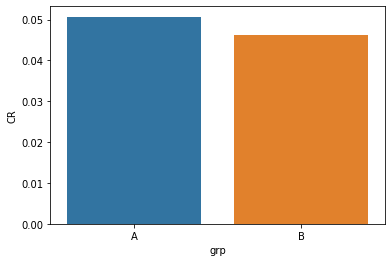

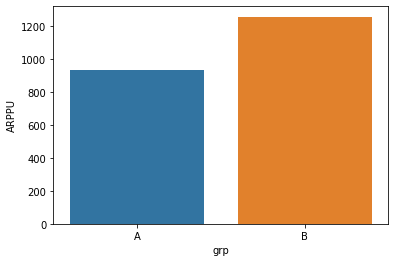

In [89]:
vizualisation(new_metrics)